In [1]:
! pip install numpy==1.26.4
! pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
! pip install matplotlib
! pip install pandas
! pip install scipy

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader
from PIL import Image
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import dice

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
image_folder = 'a0-2025-medical-image-segmentation/Dataset/Train/Image/'
mask_folder = 'a0-2025-medical-image-segmentation/Dataset/Train/Mask/'

In [5]:
image_size = (512, 512)

In [6]:
# Standard normalization values used for ImageNet models
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

input_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])
target_transform = transforms.Compose([
    transforms.Resize(image_size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

In [7]:
images = []
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    if os.path.isfile(img_path):
        image = Image.open(img_path).convert('RGB')
        image = input_transform(image)
        images.append(image)
image_tensors = torch.stack(images)

In [8]:
masks = []
for filename in os.listdir(mask_folder):
    img_path = os.path.join(mask_folder, filename)
    if os.path.isfile(img_path):
        mask = Image.open(img_path)
        mask = target_transform(mask)
        masks.append(mask)
mask_tensors = torch.stack(masks)

In [9]:
train_set = torch.utils.data.TensorDataset(image_tensors, mask_tensors)

In [10]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [11]:
model = deeplabv3_resnet50(weights=None, weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT, num_classes=2, aux_loss=True).to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
epochs = 50

In [14]:
model.train()
for epoch in range(epochs):
    losses_epoch = 0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)

        outputs = model(imgs)

        loss = criterion(outputs['out'], masks)
        if 'aux' in outputs:
            aux_loss = criterion(outputs['aux'], masks)
            loss += 0.4 * aux_loss  # typical weight for aux loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_epoch += loss.item()

    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")

Epoch 1, Loss: 79.2345
Epoch 2, Loss: 49.0410
Epoch 3, Loss: 37.5409
Epoch 4, Loss: 34.1186
Epoch 5, Loss: 28.5621
Epoch 6, Loss: 26.9070
Epoch 7, Loss: 23.1579
Epoch 8, Loss: 20.2049
Epoch 9, Loss: 17.8537
Epoch 10, Loss: 16.9718
Epoch 11, Loss: 14.9830
Epoch 12, Loss: 13.9543
Epoch 13, Loss: 13.1162
Epoch 14, Loss: 12.8919
Epoch 15, Loss: 12.1684
Epoch 16, Loss: 11.1685
Epoch 17, Loss: 10.2925
Epoch 18, Loss: 9.9520
Epoch 19, Loss: 10.5722
Epoch 20, Loss: 9.3703
Epoch 21, Loss: 8.5524
Epoch 22, Loss: 8.1111
Epoch 23, Loss: 7.9372
Epoch 24, Loss: 7.8708
Epoch 25, Loss: 7.5642
Epoch 26, Loss: 7.7243
Epoch 27, Loss: 7.2059
Epoch 28, Loss: 6.8576
Epoch 29, Loss: 6.7557
Epoch 30, Loss: 6.4993
Epoch 31, Loss: 6.3717
Epoch 32, Loss: 6.1923
Epoch 33, Loss: 12.7202
Epoch 34, Loss: 9.0131
Epoch 35, Loss: 6.1956
Epoch 36, Loss: 5.4218
Epoch 37, Loss: 5.0798
Epoch 38, Loss: 4.9015
Epoch 39, Loss: 4.8791
Epoch 40, Loss: 4.7901
Epoch 41, Loss: 4.8342
Epoch 42, Loss: 4.6516
Epoch 43, Loss: 6.9223
E

In [15]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [16]:
preds = torch.zeros(1, image_size[0], image_size[1])
truths = torch.zeros(1, 1, image_size[0], image_size[1])
with torch.no_grad():
    for imgs, masks in train_loader:
        preds = torch.cat((preds, torch.argmax(model(imgs.to(device))['out'].cpu(), dim=1)), 0)
        truths = torch.cat((truths, masks), 0)

preds = preds[1:]
truths = truths[1:].squeeze()

In [17]:
def dice_coef(y_true, y_pred):
    num_images = len(y_true)
    dice_avg = 0
    for i in range(num_images):
        y_true_f = y_true[i].flatten()
        y_pred_f = y_pred[i].flatten()
        # intersection = np.sum(y_true_f * y_pred_f)
        # dice_avg += (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
        dice_avg += (1 - dice(y_true_f, y_pred_f))
    return dice_avg / num_images

In [18]:
dice_coef(truths.numpy(), preds.numpy())

0.971283219957194

In [19]:
def unnormalize(image, mean, std):
    """
    Undo normalization on an image tensor.
    
    image: tensor [C, H, W]
    mean: list of means per channel
    std: list of stds per channel
    returns: unnormalized image tensor
    """
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.022830546..1.0855688].


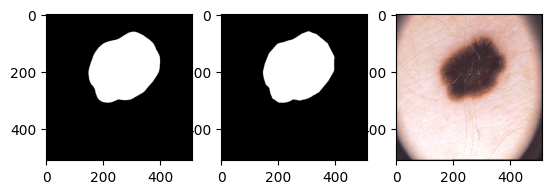

0.990918396236688


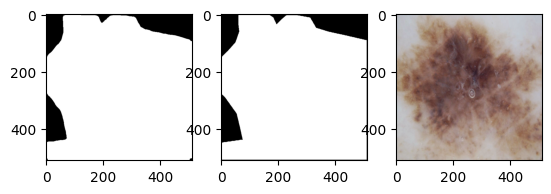

0.9947503605878557


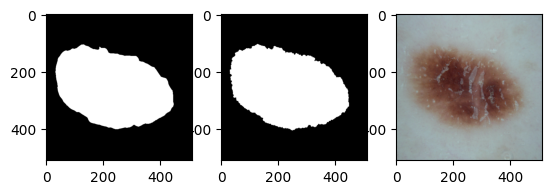

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2829131..2.0609243].


0.9889557110599387


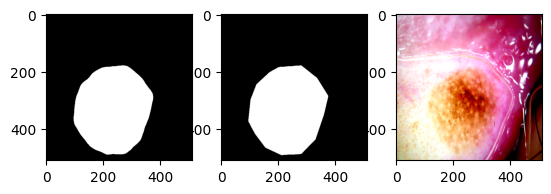

0.9920281836453558


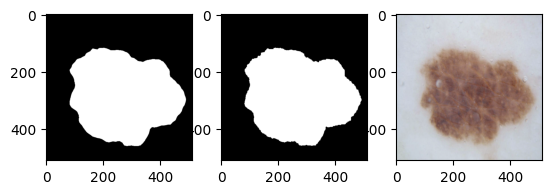

0.9956950601802941


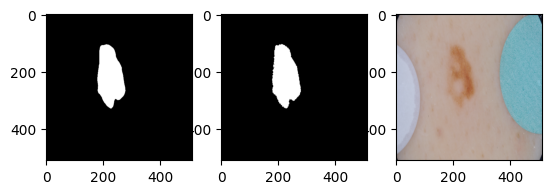

0.9831070312998024


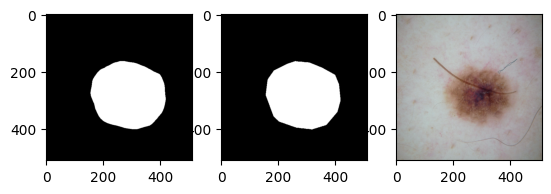

0.9945710963958955


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0027015..1.7457983].


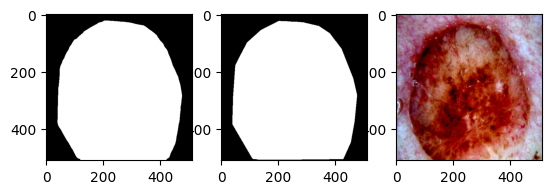

0.9963238869546612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.094994396..1.0815775].


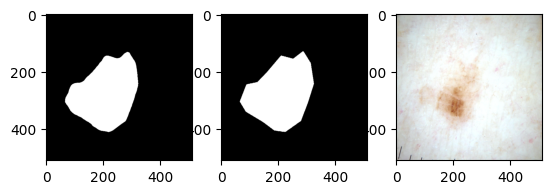

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.0356476].


0.9948081604515392


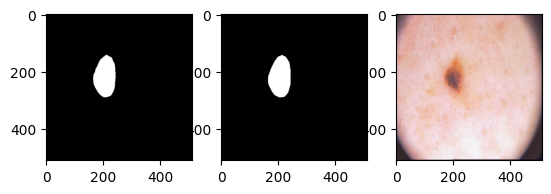

0.9864071152878


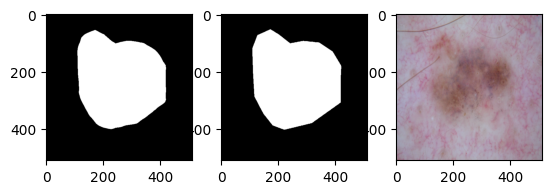

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42753804..2.4308496].


0.994997180665363


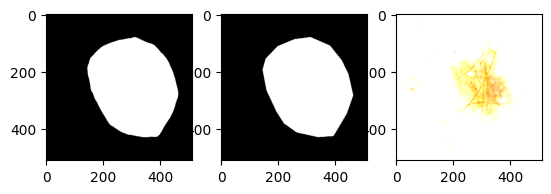

0.9923403436624461


In [20]:
with torch.no_grad():
    for i, (imgs, masks) in enumerate(train_loader):
        imgs = imgs.to(device)
        outputs = model(imgs)['out']

        imgs = unnormalize(imgs, imagenet_mean, imagenet_std)

        for j in range(min(4, imgs.size(0))):
            plt.subplot(131)
            pred_mask = torch.argmax(outputs[j], dim=0).cpu().numpy()
            plt.imshow(pred_mask, cmap='gray')
            plt.subplot(132)
            truth_mask = masks.squeeze().cpu().numpy()[j]
            plt.imshow(truth_mask, cmap='gray')
            plt.subplot(133)
            plt.imshow(imgs.permute(0, 2, 3, 1).cpu().numpy()[j])
            plt.show()
            print(1 - dice(truth_mask.flatten(), pred_mask.flatten()))

        if i == 2:
            break

In [21]:
dice_sum = 0
i = 0

for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    image = Image.open(img_path).convert('RGB')
    orig_width, orig_height = image.size

    image = transforms.Resize(image_size)(image)
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)(image)

    with torch.no_grad():
        pred_mask_tensor = torch.argmax(model(image.unsqueeze(0).to(device))['out'].squeeze(), dim=0).cpu().to(torch.uint8)

    pred_mask = transforms.functional.to_pil_image(pred_mask_tensor)
    pred_mask = np.array(transforms.Resize((orig_height, orig_width))(pred_mask))

    mask_path = os.path.join(mask_folder, re.sub(r"jpg", "png", filename))
    truth_mask = np.array(Image.open(mask_path))
    truth_mask = np.where(truth_mask == 255, 1, 0)

    dice_sum += (1 - dice(truth_mask.flatten(), pred_mask.flatten()))
    i += 1

dice_avg = dice_sum / i

In [22]:
dice_avg

0.9708852107576826

test data

In [23]:
def mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

In [24]:
test_image_folder = 'a0-2025-medical-image-segmentation/Dataset/Test/Image/'

df_submission = pd.DataFrame(columns=['ID', 'MASK'])

for filename in os.listdir(test_image_folder):
    img_path = os.path.join(test_image_folder, filename)
    image = Image.open(img_path).convert('RGB')
    orig_width, orig_height = image.size

    image = transforms.Resize(image_size)(image)
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)(image)

    with torch.no_grad():
        pred_mask_tensor = torch.argmax(model(image.unsqueeze(0).to(device))['out'].squeeze(), dim=0).cpu().to(torch.uint8)

    pred_mask_image = transforms.functional.to_pil_image(pred_mask_tensor)
    pred_mask_image = np.array(transforms.Resize((orig_height, orig_width))(pred_mask_image))
    pred_mask_rle = mask_to_rle(pred_mask_image)

    id = filename.split('.')[0]
    df_submission = pd.concat([df_submission, pd.DataFrame([[id, pred_mask_rle]], columns=df_submission.columns)], ignore_index=True)

df_submission.to_csv('submission.csv', index=False)

validation run

In [25]:
train_ds, val_ds = torch.utils.data.random_split(train_set, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)

model = deeplabv3_resnet50(weights=None, weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT, num_classes=2, aux_loss=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
    model.train()
    losses_epoch = 0
    for imgs, masks in train_dl:
        imgs = imgs.to(device)
        masks = masks.squeeze(1).long().to(device)
        outputs = model(imgs)
        loss = criterion(outputs['out'], masks)
        if 'aux' in outputs:
            aux_loss = criterion(outputs['aux'], masks)
            loss += 0.4 * aux_loss  # typical weight for aux loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_epoch += loss.item()
    print(f"Epoch {epoch+1}, Loss: {losses_epoch:.4f}")
    model.eval()
    with torch.no_grad():
        valid_loss = sum(criterion(model(X.to(device))['out'], y.squeeze(1).long().to(device)).item() for X, y in val_dl)
    print('epoch {}, validation loss {}'.format(epoch+1, valid_loss))

model.eval()

preds = torch.zeros(1, image_size[0], image_size[1])
truths = torch.zeros(1, 1, image_size[0], image_size[1])
with torch.no_grad():
    for imgs, masks in val_dl:
        preds = torch.cat((preds, torch.argmax(model(imgs.to(device))['out'].cpu(), dim=1)), 0)
        truths = torch.cat((truths, masks), 0)
preds = preds[1:]
truths = truths[1:].squeeze()

dice_coef(truths.numpy(), preds.numpy())

Epoch 1, Loss: 75.1789
epoch 1, validation loss 17.825001813471317
Epoch 2, Loss: 55.5692
epoch 2, validation loss 25.0340174138546
Epoch 3, Loss: 53.0970
epoch 3, validation loss 9.911011412739754
Epoch 4, Loss: 45.6733
epoch 4, validation loss 7.620148289948702
Epoch 5, Loss: 37.5975
epoch 5, validation loss 9.229998834431171
Epoch 6, Loss: 37.8768
epoch 6, validation loss 8.587508058175445
Epoch 7, Loss: 39.7334
epoch 7, validation loss 6.6919027622789145
Epoch 8, Loss: 35.9167
epoch 8, validation loss 6.039932206273079
Epoch 9, Loss: 33.1542
epoch 9, validation loss 12.089136496186256
Epoch 10, Loss: 37.6340
epoch 10, validation loss 6.437026400119066
Epoch 11, Loss: 30.7536
epoch 11, validation loss 6.063691712915897
Epoch 12, Loss: 43.4952
epoch 12, validation loss 10.512054681777954
Epoch 13, Loss: 34.0317
epoch 13, validation loss 5.911860695108771
Epoch 14, Loss: 28.0625
epoch 14, validation loss 7.075542973354459
Epoch 15, Loss: 28.3400
epoch 15, validation loss 5.94296505674

0.9139163360991216